# Testing the Simplified Betts-Miller convection scheme

The scheme is described by [Frierson (2007), J. Atmos. Sci. 64, doi:10.1175/JAS3935.1](https://doi.org/10.1175/JAS3935.1).

This is a work in progress to wrap the Fortran code from Dargan Frierson into a climlab process.

## Building from source

For now, this what you have to do to install and use the code. First, get yourself a copy of the [source repo for climlab-sbm-convection on github](https://github.com/climlab/climlab-sbm-convection). Then do the following.

### Build environment

Here are instructions to create a build environment (including Fortran compiler) with conda/mamba

Starting from the root of the `climlab-sbm-convection` repo *(example for Apple M1 machine, see `./ci/` for other environment files)*:
```
mamba create --name sbm_build_env python=3.11 --channel conda-forge
mamba env update --file ./ci/requirements-macos-arm64.yml
conda activate sbm_build_env
```

### Building and installing into the Python environment

From the root of the repository, do this:
```
python -m pip install . --no-deps -vv
```

### Runtime environment for this notebook

To install a complete run-time environment for these notebooks, first follow the above steps for building and installing the `climlab-sbm-convection` module. Then run the following in your active `sbm_build_env` environment:

```
mamba install -c conda-forge climlab metpy jupyter matplotlib pandas ffmpeg
```

## Some trivial tests

- Can we import the complied object? 
- Does it calculate saturation vapor pressure correctly?

In [1]:
# Do these three methods for calculating saturation vapor pressure agree?

from climlab_sbm_convection import betts_miller, escomp, capecalc
from climlab.utils.thermo import clausius_clapeyron
import metpy.calc as mpcalc
from metpy.units import units

temperature = 280.  # in Kelvin
print(clausius_clapeyron(temperature))  # result in hPa
print(mpcalc.saturation_vapor_pressure(temperature * units.kelvin).to('hPa'))
print(escomp(temperature)/100.)  # convert to hPa

9.911891305211338
9.91189130521134 hectopascal
9.911895751953125


The three values agree to a high precision.

## A single column sounding

Here I'm using some sample data from the metpy package, following [this tutorial](https://unidata.github.io/MetPy/latest/tutorials/upperair_soundings.html).

### Access and plot some sounding data

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from metpy.cbook import get_test_data
from metpy.plots import Hodograph, SkewT

In [3]:
col_names = ['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed']

df = pd.read_fwf(get_test_data('may22_sounding.txt', as_file_obj=False),
                 skiprows=5, usecols=[0, 1, 2, 3, 6, 7], names=col_names)

# Drop any rows with all NaN values for T, Td, winds
df = df.dropna(subset=('temperature', 'dewpoint', 'direction', 'speed'
                       ), how='all').reset_index(drop=True)

In [4]:
# We will pull the data out of the example dataset into individual variables and assign units.

p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = df['dewpoint'].values * units.degC

In [5]:
# Calculate the Lifting Condensation Level
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
# Calculate the parcel profile.
parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')

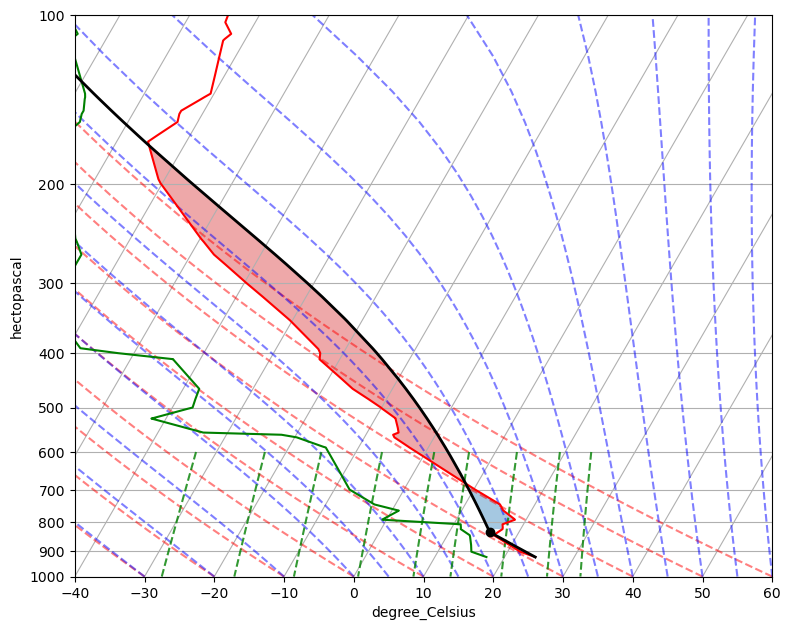

In [6]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Plot LCL temperature as black dot
skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, T, parcel_prof, Td)
skew.shade_cape(p, T, parcel_prof)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

### Convective Available Potential Energy (CAPE) and Convective Inhibition (CIN) from this sounding

In [7]:
cape_metpy, cin_metpy = mpcalc.cape_cin(p, T, Td, parcel_prof)
print("CAPE from metpy is {}".format(cape_metpy))
print("CIN from metpy is {}".format(cin_metpy))

CAPE from metpy is 2598.547323206762 joule / kilogram
CIN from metpy is -55.01036697089982 joule / kilogram


### Do we get the same CAPE and CIN values as metpy?

I will make a manual call to the `capecalc` subroutine in the compiled Fortran object.

In [8]:
from climlab.utils import constants as const

Cp_air = const.cp 
rdgas = const.Rd 
rvgas = const.Rv
HLv = const.Lhvap 
kappa = const.kappa 
es0 = 1.0
avgbl = False  # If true, the parcel is averaged in theta and r up to its LCL -- not actually implemented
Grav = const.g

# model levels are the pressure levels in the dataset
pfull = p.to(units.pascals).magnitude  # convert units and strip units away
pfull = np.flip(pfull)  # convection code expects that first element of array is TOA, last element is near-surface

# assume that the interfaces are halfway between pressure levels
num_lev = pfull.size
phalf = np.zeros(num_lev+1)
phalf[1:-1] = pfull[:-1] + np.diff(pfull)/2
phalf[-1] = 100000.  # surface pressure in Pa

# convert input arrays to the correct orientation and units
tin = np.flip(T.to(units.kelvin).magnitude)  # air temperature 
qin = np.flip(mpcalc.specific_humidity_from_dewpoint(p, Td).magnitude)  # specific humidity 
#  water vapor mixing ratio
rin = np.flip(mpcalc.mixing_ratio_from_specific_humidity(mpcalc.specific_humidity_from_dewpoint(p, Td)).magnitude)

#  Call the calccalc routine
# !    Output:
# !    cape        Convective available potential energy
# !    cin         Convective inhibition (if there's no LFC, then this is set 
# !                to zero)
# !    tp          Parcel temperature (set to the environmental temperature 
# !                where no adjustment)
# !    rp          Parcel specific humidity (set to the environmental humidity 
# !                where no adjustment, and set to the saturation humidity at 
# !                the parcel temperature below the LCL)
# !    klzb        Level of zero buoyancy
cape_sbm, cin_sbm, tp,rp,klzb = capecalc(num_lev,pfull,phalf,
                        Cp_air,rdgas,rvgas,HLv,kappa,es0,tin,rin,avgbl)

cape_sbm, cin_sbm

(2605.31640625, 122.73005676269531)

These values are fairly close to what metpy produced for the same sounding. I think the sign convention for CIN is opposite.

We can visualize the discrepancy by adding the SBM-produced parcel profile to the skew-T plot:

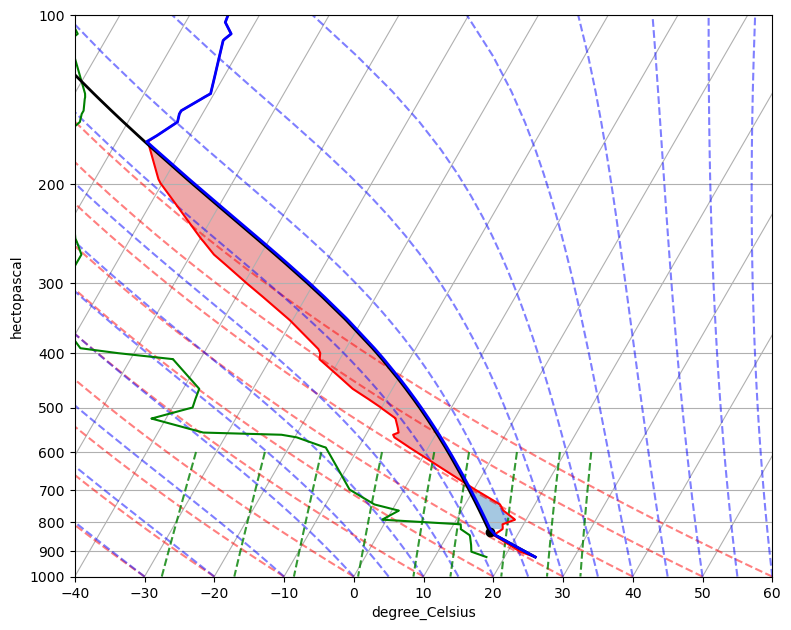

In [9]:
# add the SBM parcel profile to the existing plot
sbm_parcel_prof = np.flip(tp) * units.kelvin
skew.plot(p, sbm_parcel_prof, 'b', linewidth=2)
fig

The parcel profiles and LCL values look very similar. I'm not sure why the CIN values are different.

## Calling the `betts_miller` subroutine

Let's now pass the same sounding to the `betts_miller` Fortran subroutine, so we can compute tendencies and diagnostics from the convection scheme.

In [10]:
dt = const.seconds_per_hour * 3
tau_bm=7200.
rhbm=0.7
do_simp=False
do_shallower=True
do_changeqref=True
do_envsat=True
do_taucape=False
capetaubm=900.  # only used if do_taucape == True
tau_min=2400.   # only used if do_taucape == True
ix = 1; jx = 1; kx = num_lev

#  Convert input arrays to the expected dimensionality [ix,jx,kx]
tin_grid = tin[np.newaxis, np.newaxis, :]
qin_grid = qin[np.newaxis, np.newaxis, :]
rin_grid = rin[np.newaxis, np.newaxis, :]
pfull_grid = pfull[np.newaxis, np.newaxis, :]
phalf_grid = phalf[np.newaxis, np.newaxis, :]
rhbm_grid = rhbm * np.ones_like(tin_grid)

rain, tdel, qdel, q_ref, bmflag, klzbs, cape, cin, t_ref, invtau_bm_t, invtau_bm_q, capeflag = \
    betts_miller(dt, tin_grid, qin_grid, pfull_grid, phalf_grid, 
                                          HLv, Cp_air, Grav,
                                          rdgas,rvgas,kappa, es0, tau_bm, rhbm_grid, 
                                          do_simp, do_shallower, do_changeqref, 
                                          do_envsat, do_taucape, capetaubm, tau_min, 
                                          ix, jx, kx,)

In [11]:
cape, cin, rain, bmflag, capeflag

(array([[2605.3164]], dtype=float32),
 array([[122.73006]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32))

This is consistent with the call to `capecalc` above. We get the same CAPE and CIN. No rain is produced here.

We can also take a look at the convective tendencies for temperature and specific humidity:

In [12]:
tdel

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

In [13]:
qdel

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]], dtype=float32)

The scheme produces no convective tendencies in this case.

### Destabilize the surface with added moisture

We're going to create some deep convection by adding moisture to the profile. The SBM scheme will not produce deep convection unless both conditions are met:

$$P_q = -\int_{p_0}^{p_{LZB}} \delta q ~ dp/g > 0 $$
$$P_T = \int_{p_0}^{p_{LZB}} \frac{c_p}{L} \delta T ~ dp/g > 0 $$

(Frierson 2007, equations 3 and 4).

The positive CAPE in our profile means that we will meet the condition $P_T > 0$, but there is not enough moisture relative to the reference profile. So let's add more!

In [14]:
Tmoist = T * np.ones_like(T) # unchanged temperature
Td_moist = Td + 5.*units('delta_degC')  # increased dewpoint

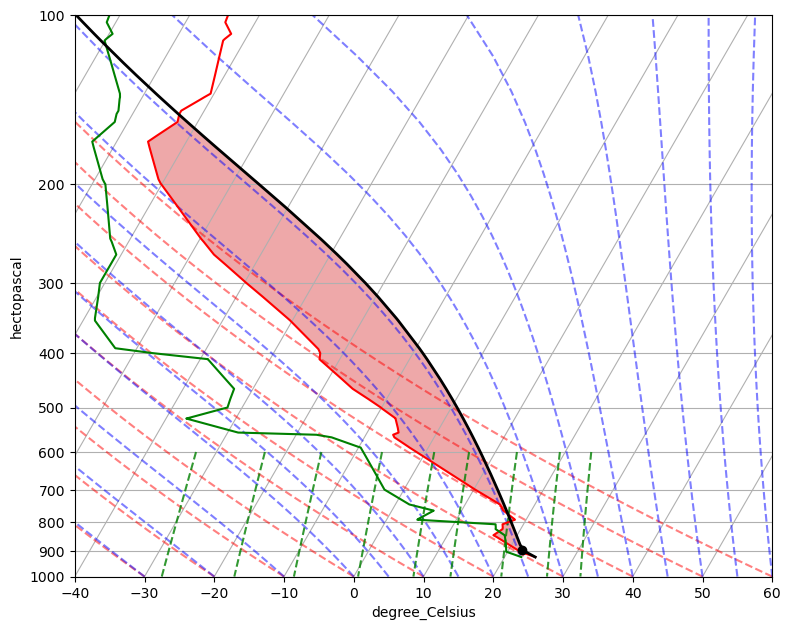

In [15]:
# Create a new figure. The dimensions here give a good aspect ratio
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, Tmoist, 'r')
skew.plot(p, Td_moist, 'g')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)


# Calculate the LCL
lcl_pressure_moist, lcl_temperature_moist = mpcalc.lcl(p[0], Tmoist[0], Td_moist[0])
# Calculate the parcel profile.
parcel_prof_moist = mpcalc.parcel_profile(p, Tmoist[0], Td_moist[0]).to('degC')
# Plot LCL temperature as black dot
skew.plot(lcl_pressure_moist, lcl_temperature_moist, 'ko', markerfacecolor='black')

# Plot the parcel profile as a black line
skew.plot(p, parcel_prof_moist, 'k', linewidth=2)

# Shade areas of CAPE and CIN
skew.shade_cin(p, Tmoist, parcel_prof_moist, Td_moist)
skew.shade_cape(p, Tmoist, parcel_prof_moist)

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

In [16]:
cape_metpy_moist, cin_metpy_moist = mpcalc.cape_cin(p, Tmoist, Td_moist, parcel_prof_moist)
print("CAPE from metpy is {}".format(cape_metpy_moist))
print("CIN from metpy is {}".format(cin_metpy_moist))

CAPE from metpy is 5814.380625662021 joule / kilogram
CIN from metpy is 0 joule / kilogram


We have reduced the CIN to zero with the added moisture!

### Call the convection scheme for our moister column

In [17]:
tin_moist = np.flip(Tmoist.to(units.kelvin).magnitude)
tin_grid_moist = tin_moist[np.newaxis, np.newaxis, :]

qin_moist = np.flip(mpcalc.specific_humidity_from_dewpoint(p, Td_moist).magnitude)
qin_grid_moist = qin_moist[np.newaxis, np.newaxis, :]

rain, tdel, qdel, q_ref, bmflag, klzbs, cape, cin, t_ref, invtau_bm_t, invtau_bm_q, capeflag = \
    betts_miller(dt, tin_grid_moist, qin_grid_moist, pfull_grid, phalf_grid, 
                                          HLv, Cp_air, Grav,
                                          rdgas,rvgas,kappa, es0, tau_bm, rhbm_grid, 
                                          do_simp, do_shallower, do_changeqref, 
                                          do_envsat, do_taucape, capetaubm, tau_min, 
                                          ix, jx, kx,)
cape, cin, rain, bmflag, capeflag

(array([[73.06134]], dtype=float32),
 array([[-5.2824445]], dtype=float32),
 array([[1.4249854]], dtype=float32),
 array([[2.]], dtype=float32),
 array([[0.]], dtype=float32))

The scheme has produced some rain!

We can plot the resulting altered temperature and dewpoint profiles:

In [18]:
Tnew = Tmoist + np.flip(tdel.squeeze()) * units('delta_degC')
qnew = mpcalc.specific_humidity_from_dewpoint(p, Td_moist) + np.flip(qdel.squeeze())
Tdnew = mpcalc.dewpoint_from_specific_humidity(p, qnew)

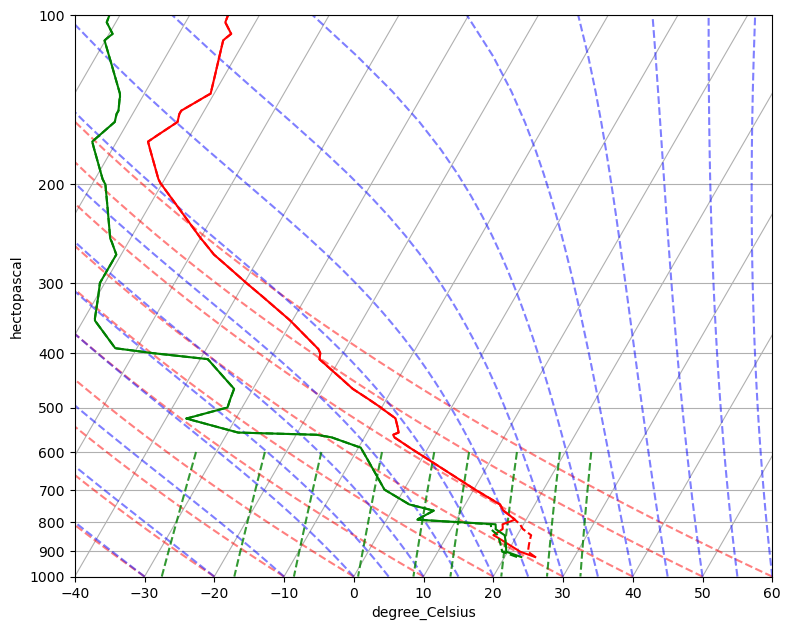

In [19]:
fig = plt.figure(figsize=(9, 9))
skew = SkewT(fig, rotation=30)

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, Tmoist, 'r')
skew.plot(p, Td_moist, 'g')
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

skew.plot(p, Tnew, 'r--')
skew.plot(p, Tdnew, 'g--')

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()

# Show the plot
plt.show()

This plot shows the change in temperature and dewpoint due to the convection. The convective warming and drying is mostly confined to the lower levels.

## Using the climlab wrapper

We can hopefully compute the same tendencies using the Python wrapper developed for climlab

In [20]:
# We have wrapped the SBM code in a climlab process:
import climlab
from simplified_betts_miller import SimplifiedBettsMiller

### Do the stable case first

In [21]:
water_depth = 10.
short_timestep = const.seconds_per_hour * 3

full_state = climlab.column_state(water_depth = water_depth, lev=p)
full_state['Tatm'][:] = tin
full_state['q'] = 0.*full_state.Tatm + qin

conv = SimplifiedBettsMiller(name='Convection',
                             state=full_state,
                             do_simp=False,
                             do_shallower=True,
                             do_envsat=True,
                             do_taucape=False,
                             timestep=short_timestep,
                         )  
print(conv)

climlab Process of type <class 'simplified_betts_miller.SimplifiedBettsMiller'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (75,) 
  q: (75,) 
The subprocess tree: 
Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>



In [22]:
conv.step_forward()

In [23]:
conv.diagnostics

{'precipitation': array([0.]),
 'cape': array([2605.31640625]),
 'cin': array([122.73005676])}

In [24]:
conv.tendencies

{'Ts': Field([0.]),
 'Tatm': Field([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+

### Now the unstable case

In [25]:
conv2 = climlab.process_like(conv)
conv2.Tatm[:] = tin_moist
conv2.q[:] = qin_moist

conv2.step_forward()
conv2.diagnostics

{'precipitation': array([0.00013194]),
 'cape': array([73.06134033]),
 'cin': array([-5.28244448])}

In [26]:
conv2.tendencies['Tatm'] * short_timestep

Field([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [27]:
conv2.tendencies['q'] * short_timestep

Field([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.0006098 , -0.00061414, -0.00

Note that the precipitation is reported in different units. The Fortran code reports total precip over the timestep in kg m$^{-2}$ (or mm), while climlab reports precipitation rate in kg m$^{-2}$ s$^{-1}$ or mm s$^{-1}$:

In [28]:
print(rain)  # in mm
print(rain / conv2.timestep) # in mm/s
print(conv2.diagnostics['precipitation'])

[[1.4249854]]
[[0.00013194]]
[0.00013194]


This confirms that the climlab wrapper `SimplifiedBettsMiller` produces the same tendencies as a manual call to the Fortran object.

## Coupling to climlab processes: a Single Column Model example

Here we are going to build a complete single-column model including the following processes:

- Constant insolation
- Longwave and Shortwave radiation
- Surface turbulent fluxes of sensible and latent heat
- Moist convection

The state variables for this model will be surface temperature, air temperature, and specific humidity. This model has a simple but self-contained hydrological cycle: water is evaporated from the surface and transported aloft by the moist convection scheme.

The vertical distribution of temperature and humidity at equilibrium will be determined by the interactions between moist convection, radiation, and surface fluxes.

In [29]:
from climlab.surface import SensibleHeatFlux, LatentHeatFlux
from climlab.radiation import RRTMG, DailyInsolation, AnnualMeanInsolation
from climlab import couple
from climlab.utils import constants as const

In [30]:
num_lev = 30
water_depth = 10.
short_timestep = const.seconds_per_hour * 3
long_timestep = short_timestep*3
insolation = 342.
albedo = 0.18

# set initial conditions -- 24C at the surface, -60C at 200 hPa, isothermal stratosphere
strat_idx = 6
Tinitial = np.zeros(num_lev)
Tinitial[:strat_idx] = -60. + const.tempCtoK
Tinitial[strat_idx:] = np.linspace(-60, 22, num_lev-strat_idx) + const.tempCtoK
Tsinitial = 24. + const.tempCtoK

full_state = climlab.column_state(water_depth=water_depth, num_lev=num_lev)
full_state['Tatm'][:] = Tinitial
full_state['Ts'][:] = Tsinitial

# Use Manabe's profile as an initial condition for specific humidity
Q = full_state['Tatm'].domain.axes['lev'].points / const.ps
RHprofile = 0.7 * ((Q-0.02) / (1-0.02))
e = clausius_clapeyron(full_state['Tatm']) * RHprofile
qStrat = 5.E-6
qinitial = np.maximum(qStrat, e/full_state['Tatm'].domain.axes['lev'].points * const.Rd / const.Rv)
full_state['q'] = 0.*full_state.Tatm + qinitial

temperature_state = {'Tatm':full_state.Tatm,'Ts':full_state.Ts}
#  Surface model
shf = SensibleHeatFlux(name='Sensible Heat Flux',
                       state=temperature_state, Cd=3E-3,
                       timestep=short_timestep)
lhf = LatentHeatFlux(name='Latent Heat Flux',
                     state=full_state, Cd=3E-3,
                     timestep=short_timestep)
surface = couple([shf,lhf], name="Slab")
#  Convection scheme -- water vapor is a state variable
conv = SimplifiedBettsMiller(name='Convection',
                             state=full_state,
                             timestep=short_timestep,
                         )  
rad = RRTMG(name='Radiation',
                state=temperature_state,
                specific_humidity=full_state.q,  # water vapor is an input here, not a state variable
                albedo=albedo,
                insolation=insolation,
                timestep=long_timestep,
                icld=0, # no clouds
                )
atm = couple([rad, conv], name='Atmosphere')
moistmodel = couple([atm,surface], name='Moist column model')

print(moistmodel)

climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Tatm: (30,) 
  Ts: (1,) 
  q: (30,) 
The subprocess tree: 
Moist column model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Atmosphere: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
         SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
         LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
      Convection: <class 'simplified_betts_miller.SimplifiedBettsMiller'>
   Slab: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      Sensible Heat Flux: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      Latent Heat Flux: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [31]:
moistmodel1 = climlab.process_like(moistmodel)

In [32]:
moistmodel1.step_forward()

In [33]:
moistmodel1.q

Field([5.00000000e-06, 5.04327139e-06, 6.38814376e-06, 6.96451763e-06,
       7.28472534e-06, 7.48849388e-06, 7.62956441e-06, 1.20900224e-05,
       1.87787308e-05, 2.86472997e-05, 4.29866721e-05, 6.35248073e-05,
       9.25454919e-05, 1.33031201e-04, 1.88833016e-04, 2.64870642e-04,
       3.67365552e-04, 5.04110226e-04, 6.84776333e-04, 9.21264526e-04,
       1.22809830e-03, 1.62286408e-03, 2.12669940e-03, 2.76483064e-03,
       3.56716145e-03, 4.56891251e-03, 5.81131279e-03, 7.34234220e-03,
       9.21752476e-03, 1.55846442e-02])

In [34]:
moistmodel1.integrate_years(1)

Integrating for 2921 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.0000213556921953 years.


In [35]:
moistmodel1.Ts

Field([295.13546522])

In [36]:
moistmodel1.cape

array([157.34443665])

In [37]:
moistmodel1.subprocess['Atmosphere'].subprocess['Convection'].diagnostics

{'precipitation': array([0.]),
 'cape': array([157.34443665]),
 'cin': array([0.])}

In [38]:
moistmodel1.subprocess['Atmosphere'].subprocess['Convection'].timeave

{}

This model produces convective moistening above the surface.

In [39]:
moistmodel1.q - qinitial

Field([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 9.57735894e-05, 2.29455127e-04,
       4.55056414e-04, 7.78182968e-04, 1.19027745e-03, 1.67114128e-03,
       2.19532617e-03, 2.74813667e-03, 3.31913091e-03, 3.89376890e-03,
       4.45492340e-03, 4.98405357e-03, 5.45899322e-03, 6.05564002e-03,
       6.43705927e-03, 6.66331848e-03, 6.76560998e-03, 6.71686335e-03,
       6.48780426e-03, 6.04286263e-03, 5.34198040e-03, 4.33787376e-03,
       2.97302422e-03, 3.56545466e-04])

In [40]:
moistmodel1.integrate_years(1)

Integrating for 2921 steps, 365.2422 days, or 1 years.
Total elapsed time is 1.999700472727412 years.


In [41]:
moistmodel1.timeave['precipitation']

array([4.23118048e-05])

In [42]:
moistmodel1.precipitation

array([0.])

This model must experience some sporadic precipitation events.

In [43]:
steps0 = moistmodel1.time['steps']
moistmodel1.step_forward()
while moistmodel1.precipitation[0] == 0.:
    moistmodel1.step_forward()
moistmodel1.time['steps'] - steps0

4

In [44]:
steps0 = moistmodel1.time['steps']
moistmodel1.step_forward()
while moistmodel1.precipitation[0] == 0.:
    moistmodel1.step_forward()
moistmodel1.time['steps'] - steps0

6

In [45]:
steps0 = moistmodel1.time['steps']
moistmodel1.step_forward()
while moistmodel1.precipitation[0] == 0.:
    moistmodel1.step_forward()
moistmodel1.time['steps'] - steps0

6

There is rain every sixth timestep in this configuration.

Time averaged precip and evaporation rates in mm / year

In [46]:
print(moistmodel1.timeave['precipitation'] * const.seconds_per_year)
print(moistmodel1.timeave['evaporation'] * const.seconds_per_year)

[1335.23049735]
[1338.83216581]


### What about starting with a dry column and letting it moisten itself?

In [47]:
moistmodel2 = climlab.process_like(moistmodel)
moistmodel2.q[:] = qStrat
moistmodel2.q

Field([5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06,
       5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06,
       5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06,
       5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06, 5.e-06])

In [48]:
moistmodel2.integrate_years(1)

Integrating for 2921 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9996791170352166 years.


In [49]:
moistmodel2.q

Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
       5.00000000e-06, 5.00000000e-06, 8.55725020e-05, 2.02525334e-04,
       4.03568410e-04, 6.98905819e-04, 1.08494727e-03, 1.54761989e-03,
       2.06592591e-03, 2.62545894e-03, 3.22046387e-03, 3.84210271e-03,
       4.48057560e-03, 5.12535633e-03, 5.76585382e-03, 6.39443880e-03,
       7.00456365e-03, 7.47003956e-03, 8.02017591e-03, 8.57294739e-03,
       9.10816435e-03, 9.63014344e-03, 1.01386863e-02, 1.06365703e-02,
       1.11337461e-02, 1.51187832e-02])

In [50]:
moistmodel2.Ts

Field([294.45598316])

In [51]:
moistmodel2.integrate_years(5)

Integrating for 14609 steps, 1826.2110000000002 days, or 5 years.
Total elapsed time is 5.999443656839214 years.


In [52]:
moistmodel2.q

Field([5.00000000e-06, 5.00000000e-06, 5.00000000e-06, 5.00000000e-06,
       5.00000000e-06, 5.00000000e-06, 1.42979664e-04, 3.32382760e-04,
       6.33431945e-04, 1.04506137e-03, 1.55072979e-03, 2.12510507e-03,
       2.74429065e-03, 3.40152302e-03, 4.08710291e-03, 4.72920041e-03,
       5.54310016e-03, 6.22775455e-03, 6.89127558e-03, 7.53488718e-03,
       8.15784527e-03, 8.76053927e-03, 9.34526122e-03, 9.91376365e-03,
       1.04676529e-02, 1.10063826e-02, 1.15321584e-02, 1.20455746e-02,
       1.25506358e-02, 1.61601608e-02])

In [53]:
moistmodel2.Ts

Field([296.30997349])

Looks like this version is tending toward the same climate! That's good.

## Animating the adjustment to equilibrium

This code is ugly but it makes a cool visualization where we can see the adjustment from an initial condition toward an equilibrium.

Adapted from [this chapter of The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/rce.html#adjustment-toward-radiative-convective-equilibrium) by Brian Rose.

In [54]:
#  Some imports needed to make and display animations
from IPython.display import HTML
from matplotlib import animation
import xarray as xr

def get_tendencies(model):
    '''Pack all the subprocess tendencies into xarray.Datasets
    and convert to units of K / day'''
    tendencies_Tatm = xr.Dataset()
    tendencies_sfc = xr.Dataset()
    tendencies_q = xr.Dataset()
    for name, proc, top_proc in climlab.utils.walk.walk_processes(model, topname='Total', topdown=False):
        tendencies_Tatm[name] = proc.tendencies['Tatm'].to_xarray()
        tendencies_sfc[name] = proc.tendencies['Ts'].to_xarray()
        if 'q' in proc.tendencies:
            tendencies_q[name] = proc.tendencies['q'].to_xarray()
    for tend in [tendencies_Tatm, tendencies_sfc]:
        #  convert to K / day
        tend *= climlab.constants.seconds_per_day
    return tendencies_Tatm, tendencies_sfc, tendencies_q

def initial_figure(model):
    fig = plt.figure(figsize=(10,6))
    lines = []
    
    skew = SkewT(fig, subplot=(1,2,1), rotation=30)
    #  plot the initial condition
    skew.plot(model.lev, model.Tatm - const.tempCtoK, color='black', linestyle='-', linewidth=2, label='Initial condition')
    Td = mpcalc.dewpoint_from_specific_humidity(pressure=model.lev*units('hPa'), specific_humidity=model.q)
    skew.plot(model.lev, Td, color='black', linestyle='--', linewidth=1)
    lines.append(skew.plot(model.lev, model.Tatm - const.tempCtoK, 
              linestyle='-', linewidth=2, color='C0', label='Single-column model')[0])
    lines.append(skew.plot(model.lev, Td,
              linestyle='--', linewidth=1, color='C0',)[0])
    skew.ax.legend()
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-60, 75)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    skew.ax.set_xlabel('Temperature ($^\circ$C)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    lines.append(skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
                  markersize=8, color='C0', )[0])

    ax = fig.add_subplot(1,2,2, sharey=skew.ax)
    ax.set_ylim(1050, 10)
    ax.set_xlim(-8,8)
    ax.grid()
    ax.set_xlabel('Temperature tendency ($^\circ$C day$^{-1}$)', fontsize=14)

    color_cycle=['g','b','r','y','k','c','m','g','b']
    tendencies_Tatm, tendencies_sfc, tendencies_q = get_tendencies(model)
    for i, name in enumerate(tendencies_Tatm.data_vars):
        lines.append(ax.plot(tendencies_Tatm[name], model.lev, label=name, color=color_cycle[i])[0])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines.append(ax.plot(tendencies_sfc[name], 1000, 'o', markersize=8, color=color_cycle[i])[0])
    ax.legend(loc='center right');
    lines.append(skew.ax.text(-100, 50, 'Day {}'.format(int(model.time['days_elapsed'])), fontsize=12)) 
    return fig, lines

def animate(day, model, lines):
    lines[0].set_xdata(np.array(model.Tatm)-climlab.constants.tempCtoK)
    Td = mpcalc.dewpoint_from_specific_humidity(pressure=model.lev*units('hPa'), specific_humidity=model.q)
    lines[1].set_xdata(Td.magnitude)
    lines[2].set_xdata(np.array(model.Ts)-climlab.constants.tempCtoK)
    tendencies_Tatm, tendencies_sfc, tendencies_q = get_tendencies(model)
    for i, name in enumerate(tendencies_Tatm.data_vars):
        lines[3+i].set_xdata(tendencies_Tatm[name])
    for i, name in enumerate(tendencies_sfc.data_vars):
        lines[3+5+i].set_xdata(tendencies_sfc[name])
    lines[-1].set_text('Day {}'.format(int(model.time['days_elapsed'])))
    # This is kind of a hack, but without it the initial frame doesn't appear
    if day != 0:
        model.step_forward()
    return lines

### Isothermal, dry initial condition

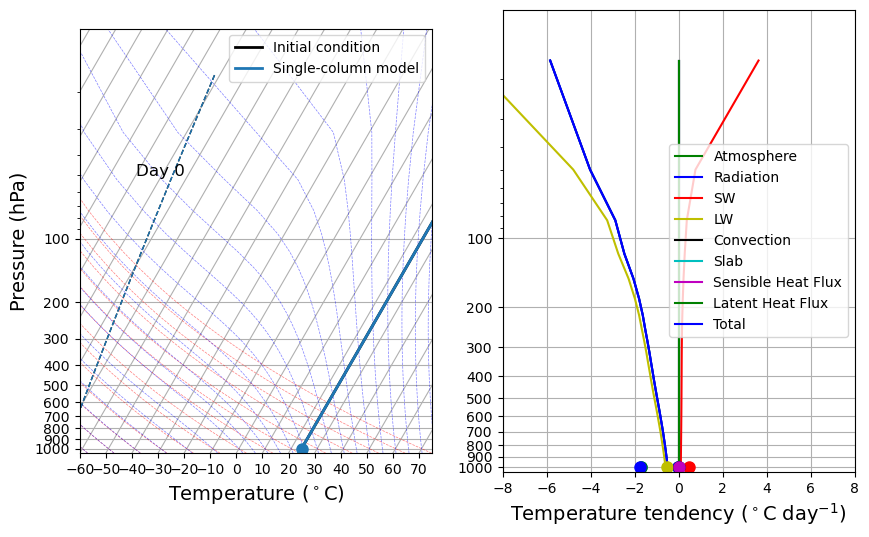

In [55]:
#  Start from isothermal and nearly dry initial state

moistmodel3 = climlab.process_like(moistmodel)
moistmodel3.q[:] = qStrat
moistmodel3.Tatm[:] = moistmodel3.Ts

#  Call the diagnostics once for initial plotting
moistmodel3.compute_diagnostics()
#  Plot initial data
fig, lines = initial_figure(moistmodel3)

In [56]:
#  This is where we make a loop over many timesteps and create an animation in the notebook
ani = animation.FuncAnimation(fig, animate, 2000, fargs=(moistmodel3, lines), interval=100)
HTML(ani.to_html5_video())